## Boosting Práctico

### Carga de Datos

Primero vamos a cargar y a preparar minimamente (split de test y train) los dos datasets que vamos a emplear: titanic para clasificación y USA_Housing para regresión.

**Clasificación**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/titanic_modified.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   MissingAge  891 non-null    int64  
 7   Spouse      891 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 55.8 KB


In [2]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Survived'])
y = df.Survived

classes = X.columns.values.tolist()

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   test_size=0.2,
                                                   random_state=55)

**Regresión**

In [3]:
df_reg = pd.read_csv('data/USA_Housing.csv')
X_reg = df_reg.drop(columns=['Price','Address'])
y_reg = df_reg['Price']
df_reg.head(2)

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06,"208 Michael Ferry Apt. 674\r\nLaurabury, NE 37..."
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06,"188 Johnson Views Suite 079\r\nLake Kathleen, ..."


In [4]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg,y_reg,
                                                                   test_size=0.2,
                                                                   random_state=55)

### Algoritmos de Boosting (I): AdaBoost y GradientBoost

En esta técnica los modelos van intentando mejorar su predecesor, recibiendo los errores del mismo, e intentando mejorar su resultado

Estos algoritmos son de los más poderosos cuando trabajamos con datos tabulares



#### AdaBoost

AdaBoost (adaptive boosting) consiste en crear varios predictores sencillos en secuencia, de tal manera que el segundo ajuste bien lo que el primero no ajustó, que el tercero ajuste un poco mejor lo que el segundo no pudo ajustar y así sucesivamente. 

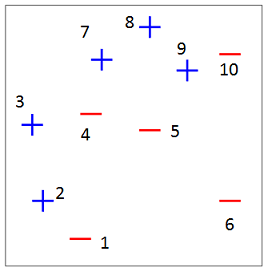
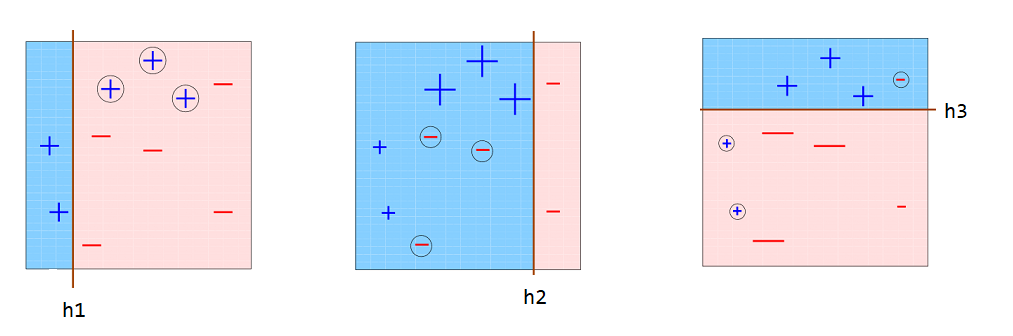
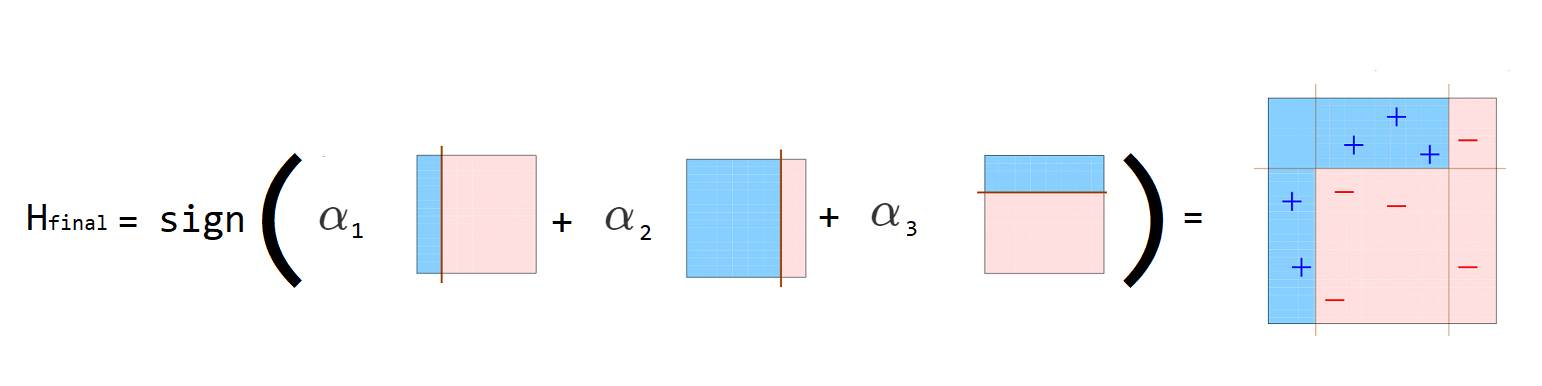

Más info: https://youtu.be/LsK-xG1cLYA

**AdaBoostClassifier**

In [5]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

ada_clf = AdaBoostClassifier(n_estimators=200, random_state=42)

ada_clf.fit(X_train, y_train)

y_pred = ada_clf.predict(X_test)
print(classification_report(y_test, y_pred))

h:\RepoBootcamp\RepoEjercicios\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.82      0.85      0.84       110
           1       0.75      0.71      0.73        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



**¿Qué hiperparámetros debería tocar en el AdaBoostClassifier?**

1. `n_estimators`: número de árboles que participarán en la corrección secuencial del error del modelo. Si corregimos el error a la perfección el algoritmo termina de entrenar. Cuantos más estimadores, mejor corregiremos el error pero mayor probabilidad de caer en overfitting. Valores superiores a 100 suelen sobreajustar el modelo aunque dependerá de la complejidad y volumen de los datos. Este es el valor que generalmente tocaremos.
2. `learning_rate`: no suele tener valores superiores a 1. Cuanto más alto, más aporta cada nuevo árbol, más preciso, pero caemos en overfitting. En general, no lo tocaremos.
3. `estimator`: se suele dejar por defecto, aunque podría encajar un SVM o una RegresiónLogística. En general, tampoco lo tocaremos. Ah y hay que pasarle un objeto del tipo de modelo que quieras emplear.

No, no hay hiperparámetros para los árboles internos. Recuerda que son "stumps" o tocones, árboles binarios con un único nivel de profundidad, no hay más que tocar. 

Antes de hacer una optimización, veamos la regresión con AdaBoostRegressor (que realmente se centra en poner pesos a los errores en la regresión de los modelos anteriores, por lo menos en [la implementación de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor), que implementa el algoritmo conocido como AdaBoost.R2)

**AdaBoostRegressor**

In [6]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

ada_reg = AdaBoostRegressor(n_estimators=200,
                               random_state=42)
ada_reg.fit(X_train_reg, 
           y_train_reg)

y_pred_reg = ada_reg.predict(X_test_reg)
print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))


MAE: 100947.80757390938
RMSE: 130082.4839115346


Puede comparar con sesiones anteriores y verás que es un error menor que en RandomForest (sin optimizar hiperparámetros)

#### Optimización de hiperparámetros


In [7]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {
    "n_estimators": [100,400],
    "learning_rate": [0.1,1,3.2]
}

model_grid = GridSearchCV(ada_reg,
                          param_grid= param_grid,
                          cv = 5,
                          scoring = "neg_mean_squared_error") # Se intenta maximizar el scoring por eso cuando la métrica es mejor cuando es más baja hay que usar las negadas

model_grid.fit(X_train_reg,y_train_reg)

GridSearchCV(cv=5,
             estimator=AdaBoostRegressor(n_estimators=200, random_state=42),
             param_grid={'learning_rate': [0.1, 1, 3.2],
                         'n_estimators': [100, 400]},
             scoring='neg_mean_squared_error')

In [8]:
model_grid.best_params_

{'learning_rate': 3.2, 'n_estimators': 400}

In [9]:
np.sqrt(-model_grid.best_score_)

np.float64(128959.73670565053)

***

### GradientBoosting

Al igual que el AdaBoost, el GradientBoost trabaja sobre un conjunto secuencial de modelos (árboles de decisión), tratando de corregir a su predecesor. Sin embargo, cuando el AdaBoost iba actualizando los pesos de cada observación, el GradientBoosting intenta ajustar y minimizar los errores (residuos) del modelo predecesor.

El modelo final será una combinación lineal de todos los estimadores.

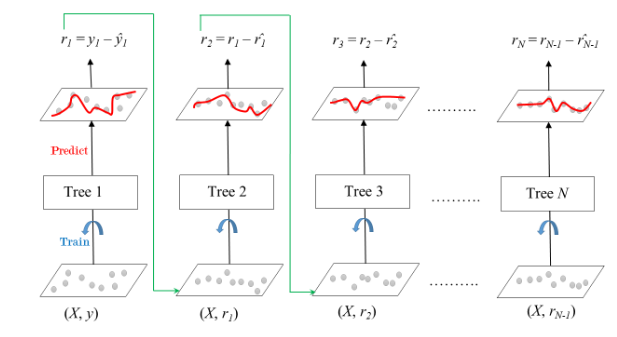

**GradientBoostingRegressor (cómo funciona, más o menos)**

Para exponer con un poco más de detalle el funcionamiento de los algoritmos de boosting, vamos a construir un problema muy similar al que usamos para ver los arboles de decisión aplicados a regresión y luego ese mismo problema lo vamos a resolver simulando un mecanismo de boosting.

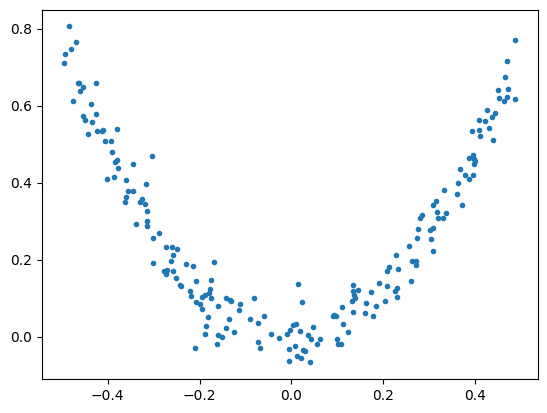

In [10]:
np.random.seed(42)
X = np.random.rand(200,1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(200)
X_test_sim = np.random.rand(100,1) - 0.5
y_test_sim = 3*X_test_sim[:, 0]**2 + 0.05 * np.random.randn(100)
plt.plot(X,y,'.')

In [11]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2,
                                 random_state=42)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [12]:
y2 = y - tree_reg1.predict(X)

In [13]:
tree_reg2 = DecisionTreeRegressor(max_depth=2,
                                 random_state=42)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [14]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2,
                                 random_state=42)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [15]:
X_new = np.array([[0.8]])
y_pred = sum([tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3)])

In [16]:
y_pred_sim = sum([tree.predict(X_test_sim) for tree in (tree_reg1, tree_reg2, tree_reg3)])


In [17]:
y_tree_reg1_pred = tree_reg1.predict(X_test_sim)

In [18]:
print("MAE, arbol 1:", mean_absolute_error(y_test_sim, y_tree_reg1_pred))
print("MAE, sim GBT:", mean_absolute_error(y_test_sim, y_pred_sim))

MAE, arbol 1: 0.10329841215879393
MAE, sim GBT: 0.06395037885778372


Pintemos como está trabajando nuestro boosting de tres árboles:

In [19]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

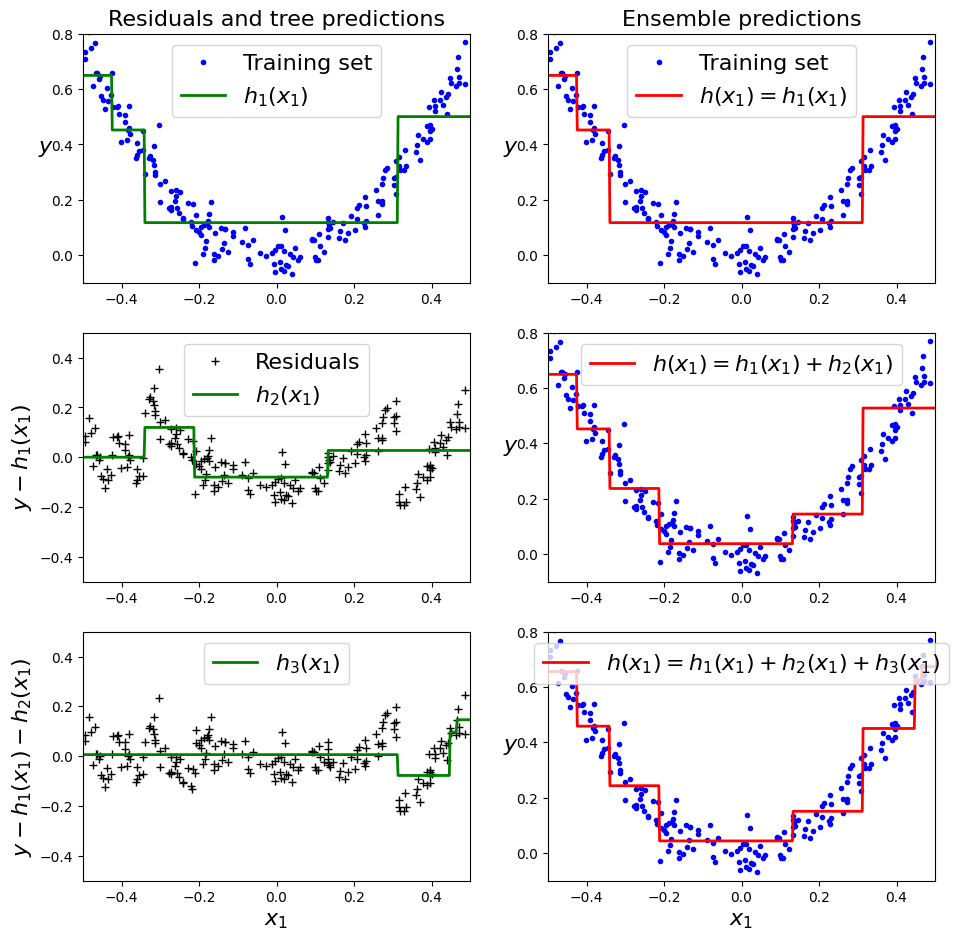

In [20]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

El truco del gradient reside en lo siguiente:

$$\hat y = \alpha_1h_1(x_) + \alpha_2h_2(x) + \alpha_3h_3(x) + ....$$

Es decir ahora tienen unos pesos y esos pesos se obtienen de aplicar gradiente descendente al error cuadrático medio de $y_{real}$ con $\hat y$. Es decir en este tipo de algoritmos no sólo son parámetros los puntos de cortes de cada uno de los árboles sino también el coeficiente que determina el peso de cada árbol en la decisión final.

Y ahora ya sí:

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor() 

gbr.fit(X_train_reg, y_train_reg)
y_pred = gbr.predict(X_test_reg)

print("MAE:", mean_absolute_error(y_test_reg, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred)))

MAE: 85550.98776896918
RMSE: 106434.51271746648


Mucho mejor, eh... Sí ya vas saboreando el poder del boosting. Veamos si también podemos tocarlo ya en clasificación.

**GradientBoostingClassifier**

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()

gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       110
           1       0.79      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



La mejora no es tan evidente (de hecho en algún caso no la hay, no el recall_medio), pero mejora el accuracy medio de los modelos ajustados de RandomForest,... pero este sin ajustar. 

**¿Qué hiperparámetros debería tocar en el GradientBoosting?**

Como los RandomForest, los GBT basados en árboles tienen hiperparámetros de modelo y tienen hiperparámetros de submodelo:

De modelo:
1. `n_estimators`: número de árboles que participarán en la corrección secuencial del error del modelo. Si corregimos el error a la perfección el algoritmo termina de entrenar. Cuantos más estimadores, mejor corregiremos el error pero mayor probabilidad de caer en overfitting. Valores superiores a 100 suelen sobreajustar el modelo aunque dependerá de la complejidad y volumen de los datos.
2. `learning_rate`: no suele tener valores superiores a 1. Cuanto más alto, más aporta cada nuevo árbol, más preciso, pero caemos en overfitting. **Importante**: un learning rate bajo y alto número de estimadores no necesariamente tiene por qué aumentar la precisión y si va a inducir en altos costes computacionales.

Observa que al incorporar un mecanismo de optimización de función de perdida (el gradiente descendente sobre el error cuadrático medio) incluye al menos un hiperparámetro de learning_rate, pero también tiene otros relacionados (que no vamos a profundizar, como tolerance (tol) o máximo número de iteraciones)

De submodelo (árboles de decisión):

3. `max_depth`: profundida de los árboles. Cuanto más profundos, más complejo es el modelo, pero menos generaliza. De  nuevo, cuanto más complejo es el problema, mayor profundidad necesitaremos. No más de 20/30 es lo normal.  
4. `max_features`: features a tener en cuenta en los splits del árbol. Cuanto más bajo, mejor generalizará y menos overfitting. Numero menor a la cantidad de features del dataset, sino dará error. Ojo porque por defecto está puesto a la raíz cuadrada del número total de features.  
5. `min_samples_split`: mínima cantidad de muestras en un nodo antes de ser spliteado. 2 por defecto. Números bajos suelen dar buenos resultados (<50). Cuanto más alto, mejor generaliza, pero más baja la precisión.  
6. `min_samples_leaf`: mínima cantidad de puntos permitidos en un `leaf node`, es decir, un nodo que no va a volver a ser spliteado. Valores bajos funcionan bien (<50).  



***

### Algoritmos de Boosting (II): XGBoost, LightGBM, CatBoost

Como ya sabes una de las limitacioones de los algoritmos de boosting es que los modelos entrenan secuencialmente, no hay otra forma de hacerlo y eso hace que de primeras sean lentos. Por eso con el tiempo han surgido implementaciones del GBT que han buscado acelerar los procesos sobre todo en los entrenamientos de los submodelos intermedios (por ejemplo la obtención de los valores de corte de las features de ramas diferentes en un arbol se pueden hacer en paralelo, o las variables numérica se pueden binnear y eso acelera el proceso de obtención de valores y no afecta excesivamente al árbol).  

Tres implementaciones "ganan" a día de hoy y son las que vamos a ver, que no solo son más rápidas que un GBT sino que además añaden sus "cositas".


## XGBoost
[XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) (exTreme Gradient Boosting) es un algoritmo que se enfoca en la velocidad de computación y el desempeño del modelo. Hace especial hincapié en la regularización (con una forma particular de aplicar penalización a la función de pérdida) y en cómo construir los árboles en cada submodelo. 


XGBoost permite regularizar el modelo y puede manejar missings, por lo que no es necesario tener el dataset perfectamente limpio

**XGBRegressor**




In [23]:
import xgboost

xgb_reg = xgboost.XGBRFRegressor(random_state=42)
xgb_reg.fit(X_train_reg, y_train_reg)
y_pred = xgb_reg.predict(X_test_reg)
print("MAE:",mean_absolute_error(y_test_reg, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred)))

MAE: 117786.651040471
RMSE: 149110.23304603703


**XGBClassifier**

In [24]:
xgb_clas = xgboost.XGBClassifier(random_state=42)

xgb_clas.fit(X_train, y_train)
y_pred = xgb_clas.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.79      0.70      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



**¿Qué hiperparámetros debería tocar en el XGB?**

Parámetros del modelo:

1. `n_estimators`: igual que para el GradientBoosting. Un detalle es que el número de submodelos puede ser menor
2. `learning_rate`: o también llamado `eta`. Como el learning rate del GradientBoosting, sirve para modular el aporte de cada nuevo arbol que se añade a la secuencia. Tiene el mismo comportamiento que un learning_rate en otros modelos, a mayor valor más rápido converge menor es la capacidad de predicción, a menor valor más tarda en converger, mayor es la capacidad (en general) y se corre el riesgo de overfitting.
- `scale_pos_weight`: es un factor de escala para aplicar a la función de pérdida para los casos en clasificación en las que el dataset está desbalanceado.

Parámetros de los submodelos:

3. `max_depth`: máximo nivel de profundidad de los árboles.
4. `min_child_weight`: equivalente a "min_sample_split" en otros modelos con árboles de sklearn.
5. `subsample`: muestreo del dataset para cada árbol (equivalente a max_samples en Random Forest)
6. `colsample_bytree`: fracción del total de variables por árbol (con un objetivo más o menos similar al "max_features" en Random Forest)

Si quieres afinar más todavía el XGBoost consulta [esta completa guía](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/).

Vamos a completar la lista de modelos y al final haremos la optimización de hiperparámetros para los tres

## LightGBM

Similar a XgBoost, desarrollado por Microsoft, es ligeramente más rápido que el resto de los que vamos a ver en esta sesión. Sin entrar en muchos detalles tiene una forma diferente de construcción de los árboles que le hace más rápido con grandes volúmenes. En general, puede generalizar peor que XGBoost que incluye la regularización como algo estándar. Maneja variables categóricas sin procesar aunque no tan bien como lo hace CatBoost. 


**LGBMRegressor**

In [25]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

lgbm_reg = LGBMRegressor(random_state=42)
lgbm_reg.fit(X_train_reg, y_train_reg)
y_pred = lgbm_reg.predict(X_test_reg)
print("MAE:",mean_absolute_error(y_test_reg, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred)))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1255
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 5
[LightGBM] [Info] Start training from score 1232594.044782
MAE: 87803.38881114805
RMSE: 109959.13432006085


**LGBMClassifier**

In [26]:
df_t = pd.read_csv("./data/titanic.csv")

In [27]:
df_t.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [28]:
features_lgbm = ["Pclass","Sex","Embarked","Age","Fare"]
features_cat = ["Sex","Embarked"]

In [29]:
df_t["Sex"] = df_t["Sex"].astype("category")
df_t["Embarked"] = df_t["Embarked"].astype("category")

In [30]:
df_t.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked       category
dtype: object

In [31]:
train_set, test_set = train_test_split(df_t, test_size=0.2, random_state= 42)

In [32]:
X_train_lgbm = train_set[features_lgbm]
y_train_lgbm = train_set["Survived"]

X_test_lgbm = test_set[features_lgbm]
y_test_lgbm = test_set["Survived"]

In [33]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
lgbm_clas = LGBMClassifier(random_state=42)

lgbm_clas.fit(X_train_lgbm, y_train_lgbm, categorical_feature= features_cat)


[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 183
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(random_state=42)

In [34]:
y_pred_lgbm = lgbm_clas.predict(X_test_lgbm)
print(classification_report(y_test_lgbm, y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       105
           1       0.79      0.73      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179





**¿Qué hiperparámetros debería tocar en el LightGBM?**
Relacionados con el modelo en general:
- `n_estimators`: Número de submodelos o estimadores máximos que contendrá mi modelo ensamblado final.
- `learning_rate`:  Tasa de aprendizaje. Un valor más pequeño significa un entrenamiento más lento pero puede mejorar la precisión del modelo. Un valor alto acelera el entrenamiento pero puedes perder precisión o capacidad (posibilidad de no converger al óptimo correcto)
- `max_bin`: Controla el número máximo de bins en los que se dividen las variables numéricas continuas para acelerar la generación de árboles. Por defecto está a 255.

Relacionados con los submodelos:
1. `max_depth` – Similar to XGBoost, this parameter instructs the trees to not grow beyond the specified depth. A higher value increases the chances for the model to overfit.
2. `num_leaves` – This parameter is very important in terms of controlling the complexity of the tree. The value should be less than 2^(max_depth) as a leaf-wise tree is much deeper than a depth-wise tree for a set number of leaves. Hence, a higher value can induce overfitting.
3. `min_data_in_leaf` – The parameter is used for controlling overfitting. A higher value can stop the tree from growing too deep but can also lead the algorithm to learn less (underfitting). According to the LightGBM’s official documentation, as a best practice, it should be set to the order of hundreds or thousands.
4. `feature_fraction` – Similar to colsample_bytree in XGBoost
5. `bagging_fraction` – Similar to subsample in XGBoost

## Catboost

Su nombre combina *Category* y *Boosting*, y funciona bien cuando tenemos muchas variables categóricas (de hecho, [las admite como inputs](https://catboost.ai/en/docs/concepts/algorithm-main-stages_cat-to-numberic)) y texto (veremos en futuros sprints como tratar variables tipo texto libre, es decir frases, párrafos en lenguaje natural, etc)

In [35]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/tidyverse/ggplot2/main/data-raw/diamonds.csv')
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [36]:
X = df.drop(columns=['price'])
y = df.price

In [37]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X,y,test_size=0.2,
                                                       random_state=1)

In [38]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error

cb = CatBoostRegressor(n_estimators=200,
                      loss_function='RMSE',
                       learning_rate=0.4,
                       random_state=1,
                       verbose = False
                      )
pool_train = Pool(X_train2, y_train2,
                 cat_features=['cut','color','clarity'])

pool_test = Pool(X_test2, cat_features=['cut','color','clarity'])

cb.fit(pool_train)
y_pred = cb.predict(pool_test)

print('RMSE:', np.sqrt(mean_squared_error(y_test2,y_pred)))

RMSE: 529.5700855716822


In [39]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier(iterations = 200,
                        learning_rate = 0.9,
                        verbose = False)
pool_train = Pool(X_train, y_train)
pool_test = Pool(X_test)
cb.fit(pool_train)

In [40]:
y_pred_cat = cb.predict(pool_test)
print(classification_report(y_test,y_pred_cat))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       110
           1       0.76      0.64      0.69        69

    accuracy                           0.78       179
   macro avg       0.78      0.76      0.76       179
weighted avg       0.78      0.78      0.78       179



#### Hiperparámetros:

CatBoost ofrece una variedad de hiperparámetros para controlar el entrenamiento del modelo y mejorar su rendimiento. Algunos de los hiperparámetros más importantes son:

Del modelo:
- `iterations`: Número de árboles a entrenar. Es equivalente a `n_estimators` en otros modelos de boosting.
- `l2_leaf_reg`: Coeficiente para el término de regularización L2 del coste. Puede ser utilizado para balancear la sobre-adaptación del modelo.
- `border_count`: Número de divisiones para características numéricas. Es similar a `max_bin` en LightGBM. (XGBoost, Catboost y LightGBM hacen binning de las variables numéricas y usa los índices en vez de las valores reales para hacer los árboles internos, por eso el número de bins o "categorias" para discretizar los valores numéricos es un hiperparámetro)
- `cat_features`: Índices de características categóricas. CatBoost manejará estas características internamente, convirtiéndolas de manera óptima. [OJO ESTE NO ES UN HIPERPARAMETRO EN EL MISMO SENTIDO CON EL QUE TRATAMOS AL RESTO, pero permite emplearla como hiperparámetro en vez de hacer feature selection en el train]
- `learning_rate`: Tasa de aprendizaje del algoritmo. Un valor más bajo hace que el modelo sea más robusto a la sobre-adaptación, pero puede requerir más iteraciones.

De los árboles:
- `depth`: Profundidad de los árboles. Controla la complejidad del modelo. (Como `max_depth` en otros modelos basados en árboles)


### Ajuste de hiperparámetros
Con todos los algoritmos vistos en este notebook, es posible aplicar la optimización de hiperparámetros, utilizando las técnicas que vimos anteriormente

In [41]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost 

params_xgb = {'max_depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'subsample': [0.3,0.6,1],
          'colsample_bytree': [0.5,1],
          'n_estimators': [100, 250, 500, 750],
          }

xgb = xgboost.XGBRegressor()

clf = RandomizedSearchCV(estimator=xgb,
                        cv=4,
                        n_iter=10,
                        param_distributions=params_xgb,
                        scoring='neg_mean_squared_error' 
                        )
clf.fit(X_train_reg, y_train_reg)

RandomizedSearchCV(cv=4,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   param_distributions={'colsample_bytree': [0.5, 1],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4],
                                        'max_depth': [3, 6, 12],
                                        'n_estimators': [100, 250, 500, 750],
                                        'subsample': [0.3, 0.6, 1]},
                   scoring='neg_mean_squared_error')

In [42]:
clf.best_params_

{'subsample': 0.6,
 'n_estimators': 250,
 'max_depth': 3,
 'learning_rate': 0.3,
 'colsample_bytree': 0.5}

In [43]:
y_pred = clf.predict(X_test_reg)
print("MAE:",mean_absolute_error(y_test_reg, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred)))

MAE: 89453.45008295623
RMSE: 111726.14607068118


#### Para LightGBM

In [44]:

params_lgb = {'max_depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'bagging_fraction': [0.3,0.6,1],
          'feature_fraction': [0.5,1],
          'n_estimators': [100, 250, 500, 750],
          'max_bins': [125,250]
          }

lgb = LGBMRegressor()

clf = RandomizedSearchCV(estimator=lgb,
                        cv=4,
                        n_iter=2,
                        param_distributions=params_lgb,
                        scoring='neg_mean_squared_error' 
                        )
clf.fit(X_train_reg, y_train_reg)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 623
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 5
[LightGBM] [Info] Start training from score 1237664.563886
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Curre

RandomizedSearchCV(cv=4, estimator=LGBMRegressor(), n_iter=2,
                   param_distributions={'bagging_fraction': [0.3, 0.6, 1],
                                        'feature_fraction': [0.5, 1],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4],
                                        'max_bins': [125, 250],
                                        'max_depth': [3, 6, 12],
                                        'n_estimators': [100, 250, 500, 750]},
                   scoring='neg_mean_squared_error')

In [45]:
clf.best_params_

{'n_estimators': 100,
 'max_depth': 6,
 'max_bins': 125,
 'learning_rate': 0.1,
 'feature_fraction': 1,
 'bagging_fraction': 1}

#### Para CatBoost


In [46]:



params_cat = {'depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          #'bagging_fraction': [0.3,0.6,1], No hay hiperparámetro equivalente
          'colsample_bylevel': [0.5,1],
          'iterations': [100, 250, 500, 750],
          "border_count": [125,250]
          }

cat_model = CatBoostRegressor(verbose = False)

clf = RandomizedSearchCV(estimator=cat_model,
                        cv=4,
                        n_iter=2,
                        param_distributions=params_cat,
                        scoring='neg_mean_squared_error' 
                        )
clf.fit(X_train_reg, y_train_reg)


RandomizedSearchCV(cv=4,
                   estimator=<catboost.core.CatBoostRegressor object at 0x000001CB66364B90>,
                   n_iter=2,
                   param_distributions={'border_count': [125, 250],
                                        'colsample_bylevel': [0.5, 1],
                                        'depth': [3, 6, 12],
                                        'iterations': [100, 250, 500, 750],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4]},
                   scoring='neg_mean_squared_error')

In [47]:
clf.best_params_

{'learning_rate': 0.3,
 'iterations': 750,
 'depth': 3,
 'colsample_bylevel': 0.5,
 'border_count': 250}

En los ejercicios veremos un par de hiperparámetros relacionados con la técnica de histogram gradient boosting para LightGBM y CatBoost. 

### Tabla comparativa cuándo usar cuál modelo

# Tabla comparativa: Elección de algoritmos de boosting

| Característica / Algoritmo | Gradient Boosted Trees (sklearn) | XGBoost | CatBoost | LightGBM |
|----------------------------|----------------------------------|---------|----------|----------|
| **Manejo de grandes conjuntos de datos** | Menos eficiente | Eficiente | Eficiente | Muy eficiente |
| **Velocidad de entrenamiento** | Rápido | Muy rápido | Rápido | Muy rápido |
| **Uso de recursos computacionales** | Moderado | Moderado/Alto | Moderado | Bajo |
| **Manejo de características categóricas** | Requiere pre-procesamiento | Requiere pre-procesamiento | Excelente (soporte nativo) | Bueno (soporte nativo) |
| **Rendimiento con configuración por defecto** | Bueno | Bueno | Excelente | Bueno |
| **Prevención de sobreajuste** | Bueno (con ajuste de hiperparámetros) | Bueno (con ajuste de hiperparámetros) | Excelente | Bueno |
| **Soporte para optimización de hiperparámetros** | Amplio | Amplio | Amplio | Amplio |
| **Facilidad de uso e integración** | Alta (especialmente con el ecosistema de sklearn) | Alta | Alta | Alta |
| **Popularidad y comunidad** | Alta | Muy alta | Alta | Alta |

**Nota**: Esta tabla proporciona una visión general y las decisiones deben basarse en pruebas empíricas y requisitos específicos del proyecto.


**Lecturas recomendadas**:

[When to Choose CatBoost Over XGBoost or LightGBM](https://neptune.ai/blog/when-to-choose-catboost-over-xgboost-or-lightgbm)

[XGBoost vs LightGBM: How Are They Different](https://neptune.ai/blog/xgboost-vs-lightgbm)

[XGBoost: Everything You Need to Know](https://neptune.ai/blog/xgboost-everything-you-need-to-know)

[Understanding LightGBM Parameters (and How to Tune Them)](https://neptune.ai/blog/lightgbm-parameters-guide)